In [1]:
import os
import pandas as pd
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
def _get_images_df() -> pd.DataFrame:
    images_df: pd.DataFrame = pd.DataFrame()
    for dirname, _, filenames in os.walk('../input/A1'):
        _imgs: list = glob(f'{dirname}/*.tif')
        if len(_imgs):
            images_df = pd.concat([images_df, pd.DataFrame(_imgs)], axis=0)
    images_df.columns = ['rel_path']
    images_df['name'] = images_df['rel_path'].apply(lambda x: x.split('/')[-1])
    return images_df

### We can see the name completely encodes the information of the folder's distribution 

In [6]:
images_df = _get_images_df()
images_df

rel_path           name
0   ../input/A1/c1/r3/images/e7/c1r3e7n36.tif  c1r3e7n36.tif
1   ../input/A1/c1/r3/images/e7/c1r3e7n47.tif  c1r3e7n47.tif
2   ../input/A1/c1/r3/images/e7/c1r3e7n15.tif  c1r3e7n15.tif
3    ../input/A1/c1/r3/images/e7/c1r3e7n1.tif   c1r3e7n1.tif
4   ../input/A1/c1/r3/images/e7/c1r3e7n30.tif  c1r3e7n30.tif
..                                        ...            ...
45  ../input/A1/c3/r1/images/e3/c3r1e3n47.tif  c3r1e3n47.tif
46  ../input/A1/c3/r1/images/e3/c3r1e3n30.tif  c3r1e3n30.tif
47  ../input/A1/c3/r1/images/e3/c3r1e3n46.tif  c3r1e3n46.tif
48  ../input/A1/c3/r1/images/e3/c3r1e3n33.tif  c3r1e3n33.tif
49  ../input/A1/c3/r1/images/e3/c3r1e3n48.tif  c3r1e3n48.tif

[3206 rows x 2 columns]

#### We know for the former yellow mission that 'r' and 'c' are used to classify the texture. Then just 'e' and 'n' may encode the differrent kind of error. It could be 'e' stood for error and 'n' just was an arbitrary number to enumerate the differents samples of the same category

#### To confirm this hypothesis we will find all the unique values of 'e'

In [17]:
from typing import Tuple

names_df = pd.DataFrame()
names_df['e'] = images_df['name'].apply(lambda x: x[4:6] if str(x[4:6]).startswith('e') else '')
patterns = names_df.drop_duplicates() # .set_index(['e'])
patterns_list = sorted([_p for _p in patterns.values.flatten() if str(_p) != ''])
patterns_list

['e0', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7']

### Analysis of the patterns

In [20]:
# We find the index of the images with the former patterns

pattern_idxs = {_p: np.argwhere(images_df.where(
    images_df['name'].str[4:6] == _p, other=0)['name'].values != 0).flatten() 
                for _p in patterns_list}

Auxiliary functions

In [21]:
def _plot_samples(_idxs: list = None) -> None:
    _rows, _cols = 3, 3
    fig, axes = plt.subplots(3, 3, figsize = (10, 10))
    if _idxs is None:
        _idxs = list(np.random.randint(len(images_df), size=_rows * _cols))
    
    axes = axes.flatten()
    images = [Image.open(images_df.iloc[_i]['rel_path']) for _i in _idxs]
    labels_class = [images_df.iloc[_i]['name'] for _i in _idxs]


    for img, ax, lab in zip(images, axes, labels_class):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(lab)
    plt.tight_layout()
    plt.show()
    
def _plot_pattern_samples(_pattern: str) -> None:
    _pattern_idx = np.argwhere(images_df.where(images_df['name'].str[4:6] == _pattern, other=0)['name'].values != 0).flatten()
    _plot_samples(_idxs=_pattern_idx[np.random.randint(len(_pattern_idx), size=9)])

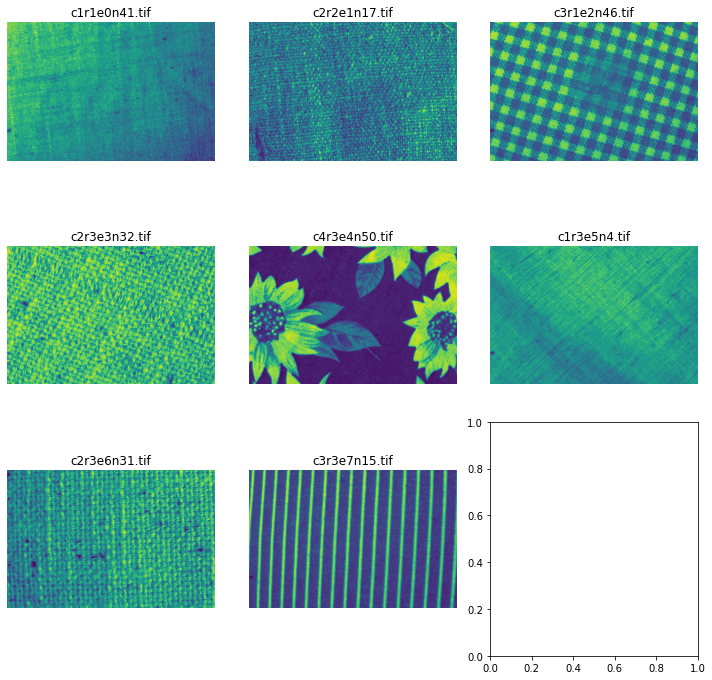

In [22]:
_idxs = [_p_idx[np.random.randint(len(_p_idx))] for _p_idx in list(pattern_idxs.values())]
_plot_samples(_idxs=_idxs)

#### For instance we can clearly see the second pattern, 'e2', corresponds to a stain in the texture. We can check it with more samples of that pattern

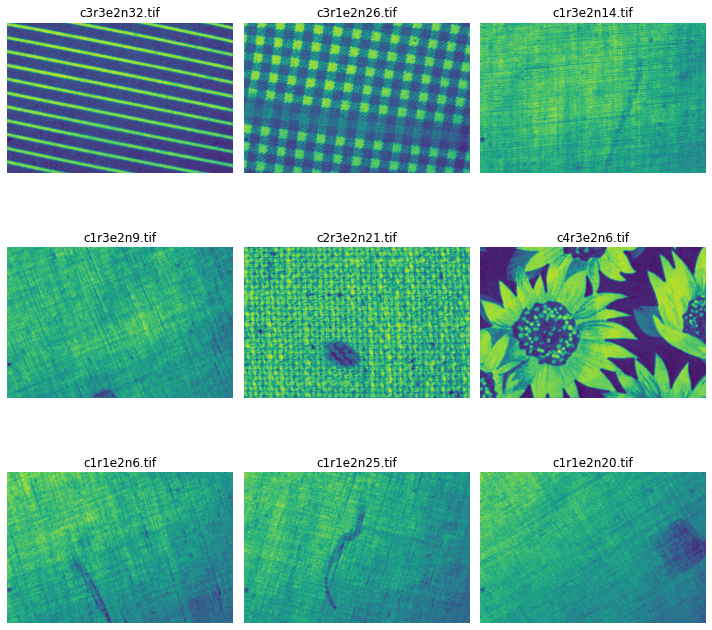

In [23]:
_plot_pattern_samples('e2')

#### Or for instance, we can also check that 'e5' stands for a fold or a crease in the texture

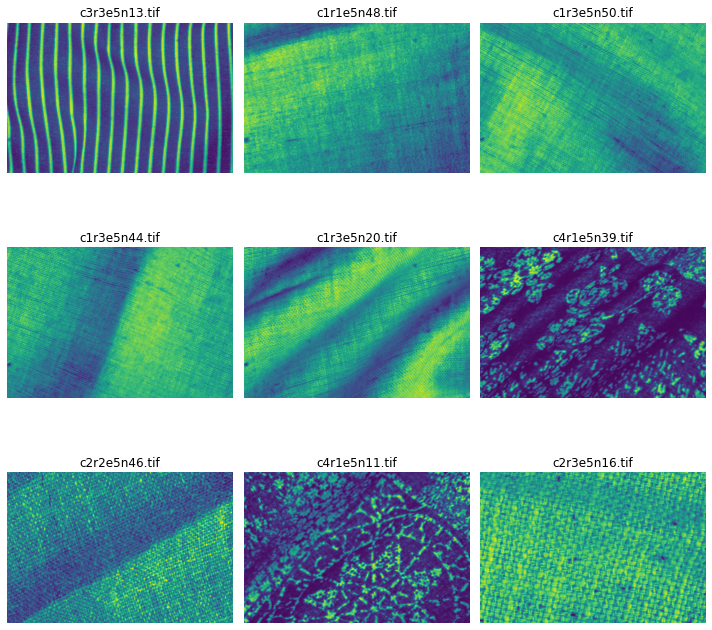

In [26]:
_plot_pattern_samples('e5')

#### We can iterate the process to exhaust all the error codes

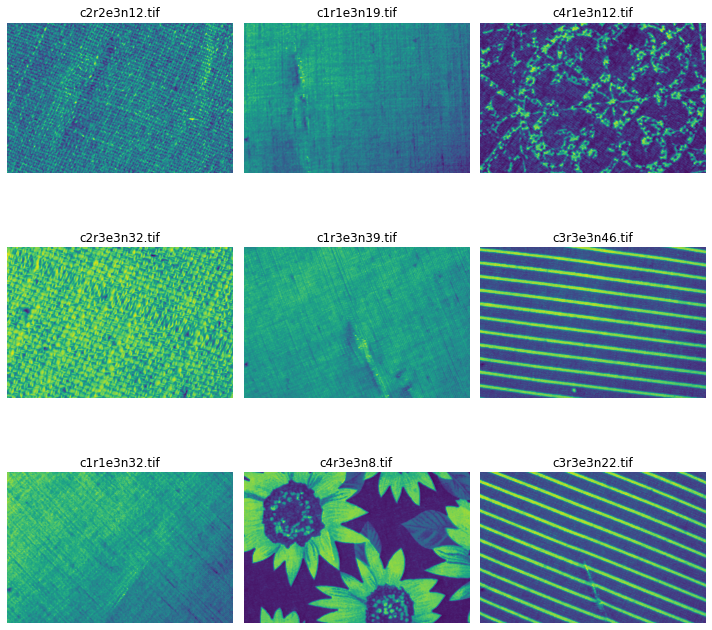

In [32]:
_plot_pattern_samples('e3')

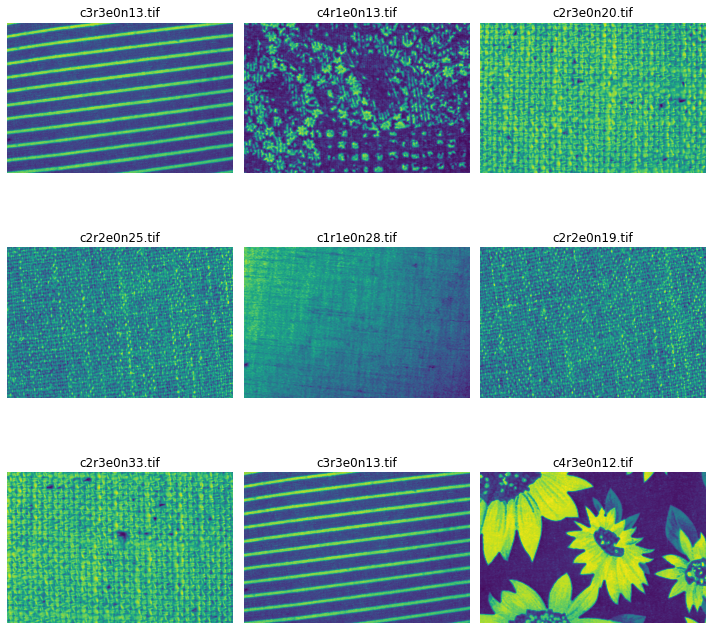

In [38]:
_plot_pattern_samples('e0')

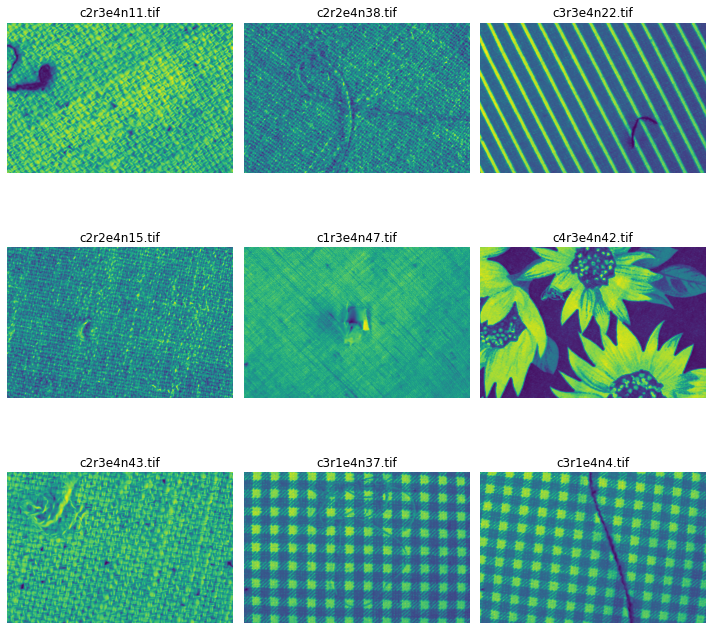

In [42]:
_plot_pattern_samples('e4')

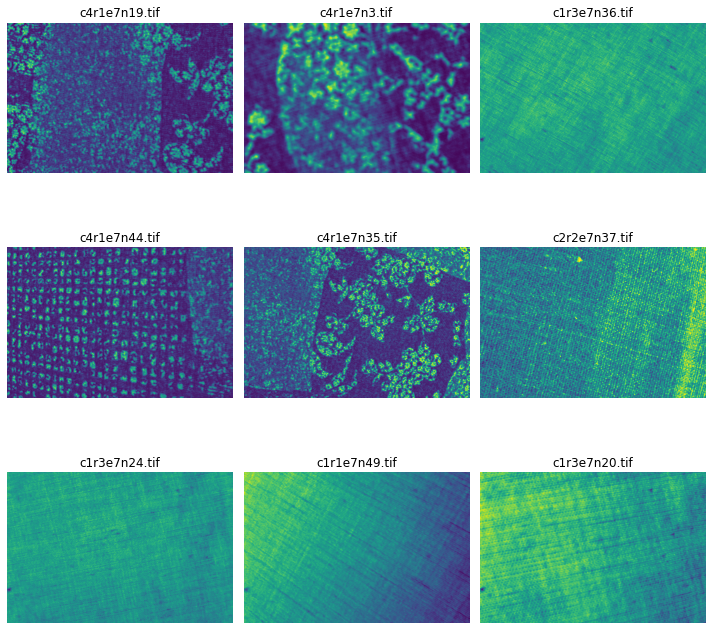

In [45]:
_plot_pattern_samples('e7')

# Conclusions

After an iterative process, it is seen:
- 'e0': no problem in the texture; denoted with class 0
- 'e1': hole; denoted with class 1
- 'e2': stain; denoted with class 2
- 'e3': defect in the thread; denoted with class 3
- 'e4': thread not belonging to the sample in the image; denoted with class 4
- 'e5': fold or crease; denoted with class 5
- 'e6': shadow or not enough light; denoted with class 6
- 'e7': camara problem (some images too near or far); denoted with class 7

Also, as below is proved, the ones that do not fulfill these criteria are not labeled but most of them seems okay:

In [39]:
_pattern_to_class = {_p: _i for _i, _p in enumerate(patterns_list)}
_pattern_to_class

{'e0': 0, 'e1': 1, 'e2': 2, 'e3': 3, 'e4': 4, 'e5': 5, 'e6': 6, 'e7': 7}

In [47]:
def _path_to_texture() -> pd.DataFrame:
    images_df = _get_images_df()
    images_df['error'] = images_df['name'].apply(lambda x: _pattern_to_class.get(x[4:6], 'unknown'))
    return images_df

_images_labeled = _path_to_texture()
_images_labeled

rel_path           name error
0   ../input/A1/c1/r3/images/e7/c1r3e7n36.tif  c1r3e7n36.tif     7
1   ../input/A1/c1/r3/images/e7/c1r3e7n47.tif  c1r3e7n47.tif     7
2   ../input/A1/c1/r3/images/e7/c1r3e7n15.tif  c1r3e7n15.tif     7
3    ../input/A1/c1/r3/images/e7/c1r3e7n1.tif   c1r3e7n1.tif     7
4   ../input/A1/c1/r3/images/e7/c1r3e7n30.tif  c1r3e7n30.tif     7
..                                        ...            ...   ...
45  ../input/A1/c3/r1/images/e3/c3r1e3n47.tif  c3r1e3n47.tif     3
46  ../input/A1/c3/r1/images/e3/c3r1e3n30.tif  c3r1e3n30.tif     3
47  ../input/A1/c3/r1/images/e3/c3r1e3n46.tif  c3r1e3n46.tif     3
48  ../input/A1/c3/r1/images/e3/c3r1e3n33.tif  c3r1e3n33.tif     3
49  ../input/A1/c3/r1/images/e3/c3r1e3n48.tif  c3r1e3n48.tif     3

[3206 rows x 3 columns]

#### As said before, they may be random but the texteure ones do not seem to present errors

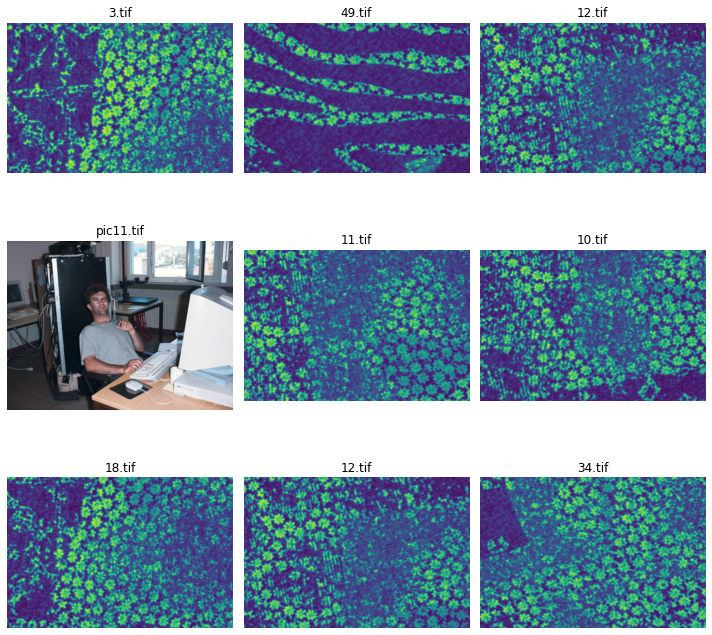

In [49]:
outliers_idx = np.argwhere(_images_labeled.where(_images_labeled['error'] == 'unknown', other=0)['error'].values != 0).flatten()
_plot_samples(_idxs=outliers_idx[np.random.randint(len(outliers_idx), size=9)])

In [51]:
_images_labeled.to_csv('red-mission.csv', index=False)